# ALGOTHON 2021 - IMPERIAL COLLEGE LONDON 
By *Daniel Plaza Herrera* and *Jonathan Sanz Carcelen*
# CHALLENGE 3: Prediction

### Import libraries

In [30]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.cluster import *
from sklearn.preprocessing import *
from sklearn.pipeline import *


from scipy.cluster.hierarchy import *

from sklearn.metrics import mean_squared_error as MSE
from sklearn.neighbors import KNeighborsClassifier as KNN

from datetime import datetime

from pprint import pprint as pp
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import *


## Challenge goals
**GOAL**: Predict Next 20-days log-return (column target_20 in the training csv file)

Models can predict the direction of return and return an action (-1,0,1)

- 1 means the model will buy and hold the stock for the next 20 days
- 0 means the model will do nothing
- -1 means the model will sell the stock and cover in 20 days

Models can also assign a weight between -1 to 1 as a portfolio holding instead.


### Import dataset

In [31]:
df = pd.read_csv('prediction_train_with_targets.csv')
df['action_20'] = df['target_20'].apply(lambda l: -1 if l < 0 else (1 if l > 0 else 0))
df.head()
df.head(5)

,IV_30.0_-75.0_mean_50,IV_30.0_-50.0_sd_50,optionvolume_ratio_sd_10,put_call_OI_sd_25,adjclose_mean_10,IV_30.0_-75.0,high_close_mean_50,logreturn_sd_50,optionvolume_ratio_sd_5,adjclose_mean_5,...,dollarvolume_ratio_mean_50,low_close_mean_25,low_close_mean_10,put_call_OI_sd_100,optionOI_ratio_mean_25,IV_30.0_50.0_mean_50,open_close_sd_25,high_close_mean_5,target_20,action_20
0,0.433818,0.032448,1.121406,0.027948,28.647753,0.382974,1.013195,0.025473,1.193495,29.315763,...,1.101670,0.981600,0.986295,0.103123,1.013351,0.419346,0.022293,1.009478,-0.196104,-1
1,0.429686,0.032721,1.155757,0.031617,28.866723,0.373258,1.013438,0.024323,1.184125,29.703249,...,1.098457,0.981762,0.985608,0.101578,1.009447,0.419145,0.022278,1.010139,-0.180574,-1
2,0.428257,0.033075,1.154503,0.035030,29.168438,0.372383,1.012878,0.024041,1.128617,30.250170,...,1.090692,0.982531,0.985778,0.099995,1.009850,0.419351,0.021743,1.011835,-0.138368,-1
3,0.428597,0.033213,1.092696,0.039074,29.376056,0.436254,1.014080,0.025199,0.577142,30.356628,...,1.095259,0.982340,0.985476,0.098712,1.008362,0.419339,0.024290,1.023331,-0.170310,-1
4,0.427857,0.033214,1.106032,0.042628,29.462332,0.414365,1.014628,0.025820,0.579427,30.030696,...,1.098127,0.983326,0.986780,0.096492,1.008108,0.420022,0.025244,1.029808,-0.195417,-1


### Insigths on financial measures of the dataset
This dataset contains information on:
- **OHLC**: An OHLC chart shows the open, high, low, and close price for a given period. It can be applied to any timeframe. The vertical line represents the high and low for the period, while the line to the left marks the open price and the line to the right marks the closing price. This entire structure is called a bar. When the close is above the open, the bar is often colored black. When the close is below the open the bar is often colored red.
- **IV**: implied volatility. It is an estimate of the future volatility of the underlying stock based on options prices. The implied volatility ratio is derived by dividing an option's implied volatility with its historical volatility, with a ratio of 1.0 being a fair price.
- **Option volume**: number of contracts traded in a market during a specific time frame, usually one trading day
- **PCR OI**: Put/Call Ratio Open Interest is calculated by dividing total number of puts open interest by the total number of calls Open Interest on a particular day. Put Call Ratio moves higher when total OI of Puts are higher than total OI of Calls while its goes down when total OI of Puts are lower than the total OI of Calls.
- **Adjusted closing value**: stock's value after accounting for any corporate actions. The closing price is the raw price, which is just the cash value of the last transacted price before the market closes. The adjusted closing price factors in corporate actions, such as stock splits, dividends, and rights offerings. The adjusted closing price can obscure the impact of key nominal prices and stock splits on prices in the short term.
- **High close**: trading strategy that stock manipulators use that entails making small trades at high prices during the final minutes of trading so as to give the impression that the stock performed really well. The use of a high close is especially popular in stocks with low liquidity and a high degree of information asymmetry. Indicators like candlestick charts can help investors determine if there were any trading manipulations.
- **Dolar volume**: total value of shares traded calculated as trading volume multiplied by price of shares.

References: https://www.investopedia.com

## Raw data visualization

Text(0.5, 1.0, 'Target observations')

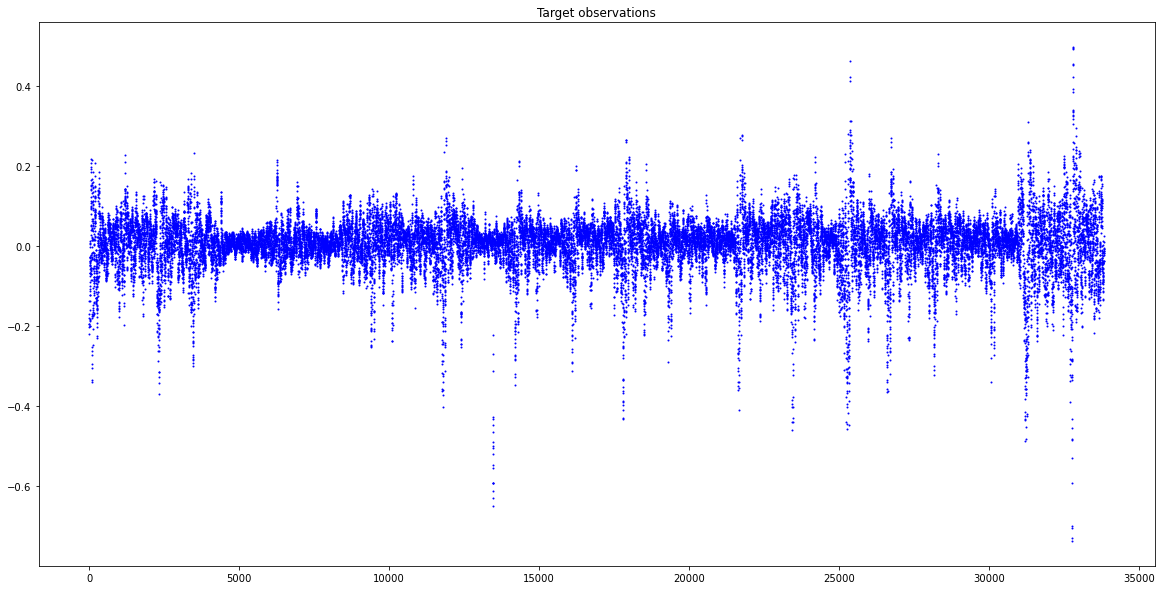

In [32]:
plt.figure(figsize=(20,10))
plt.scatter(df.index, df['target_20'], s=1, c='b')
plt.title('Target observations')

### Correlation matrix

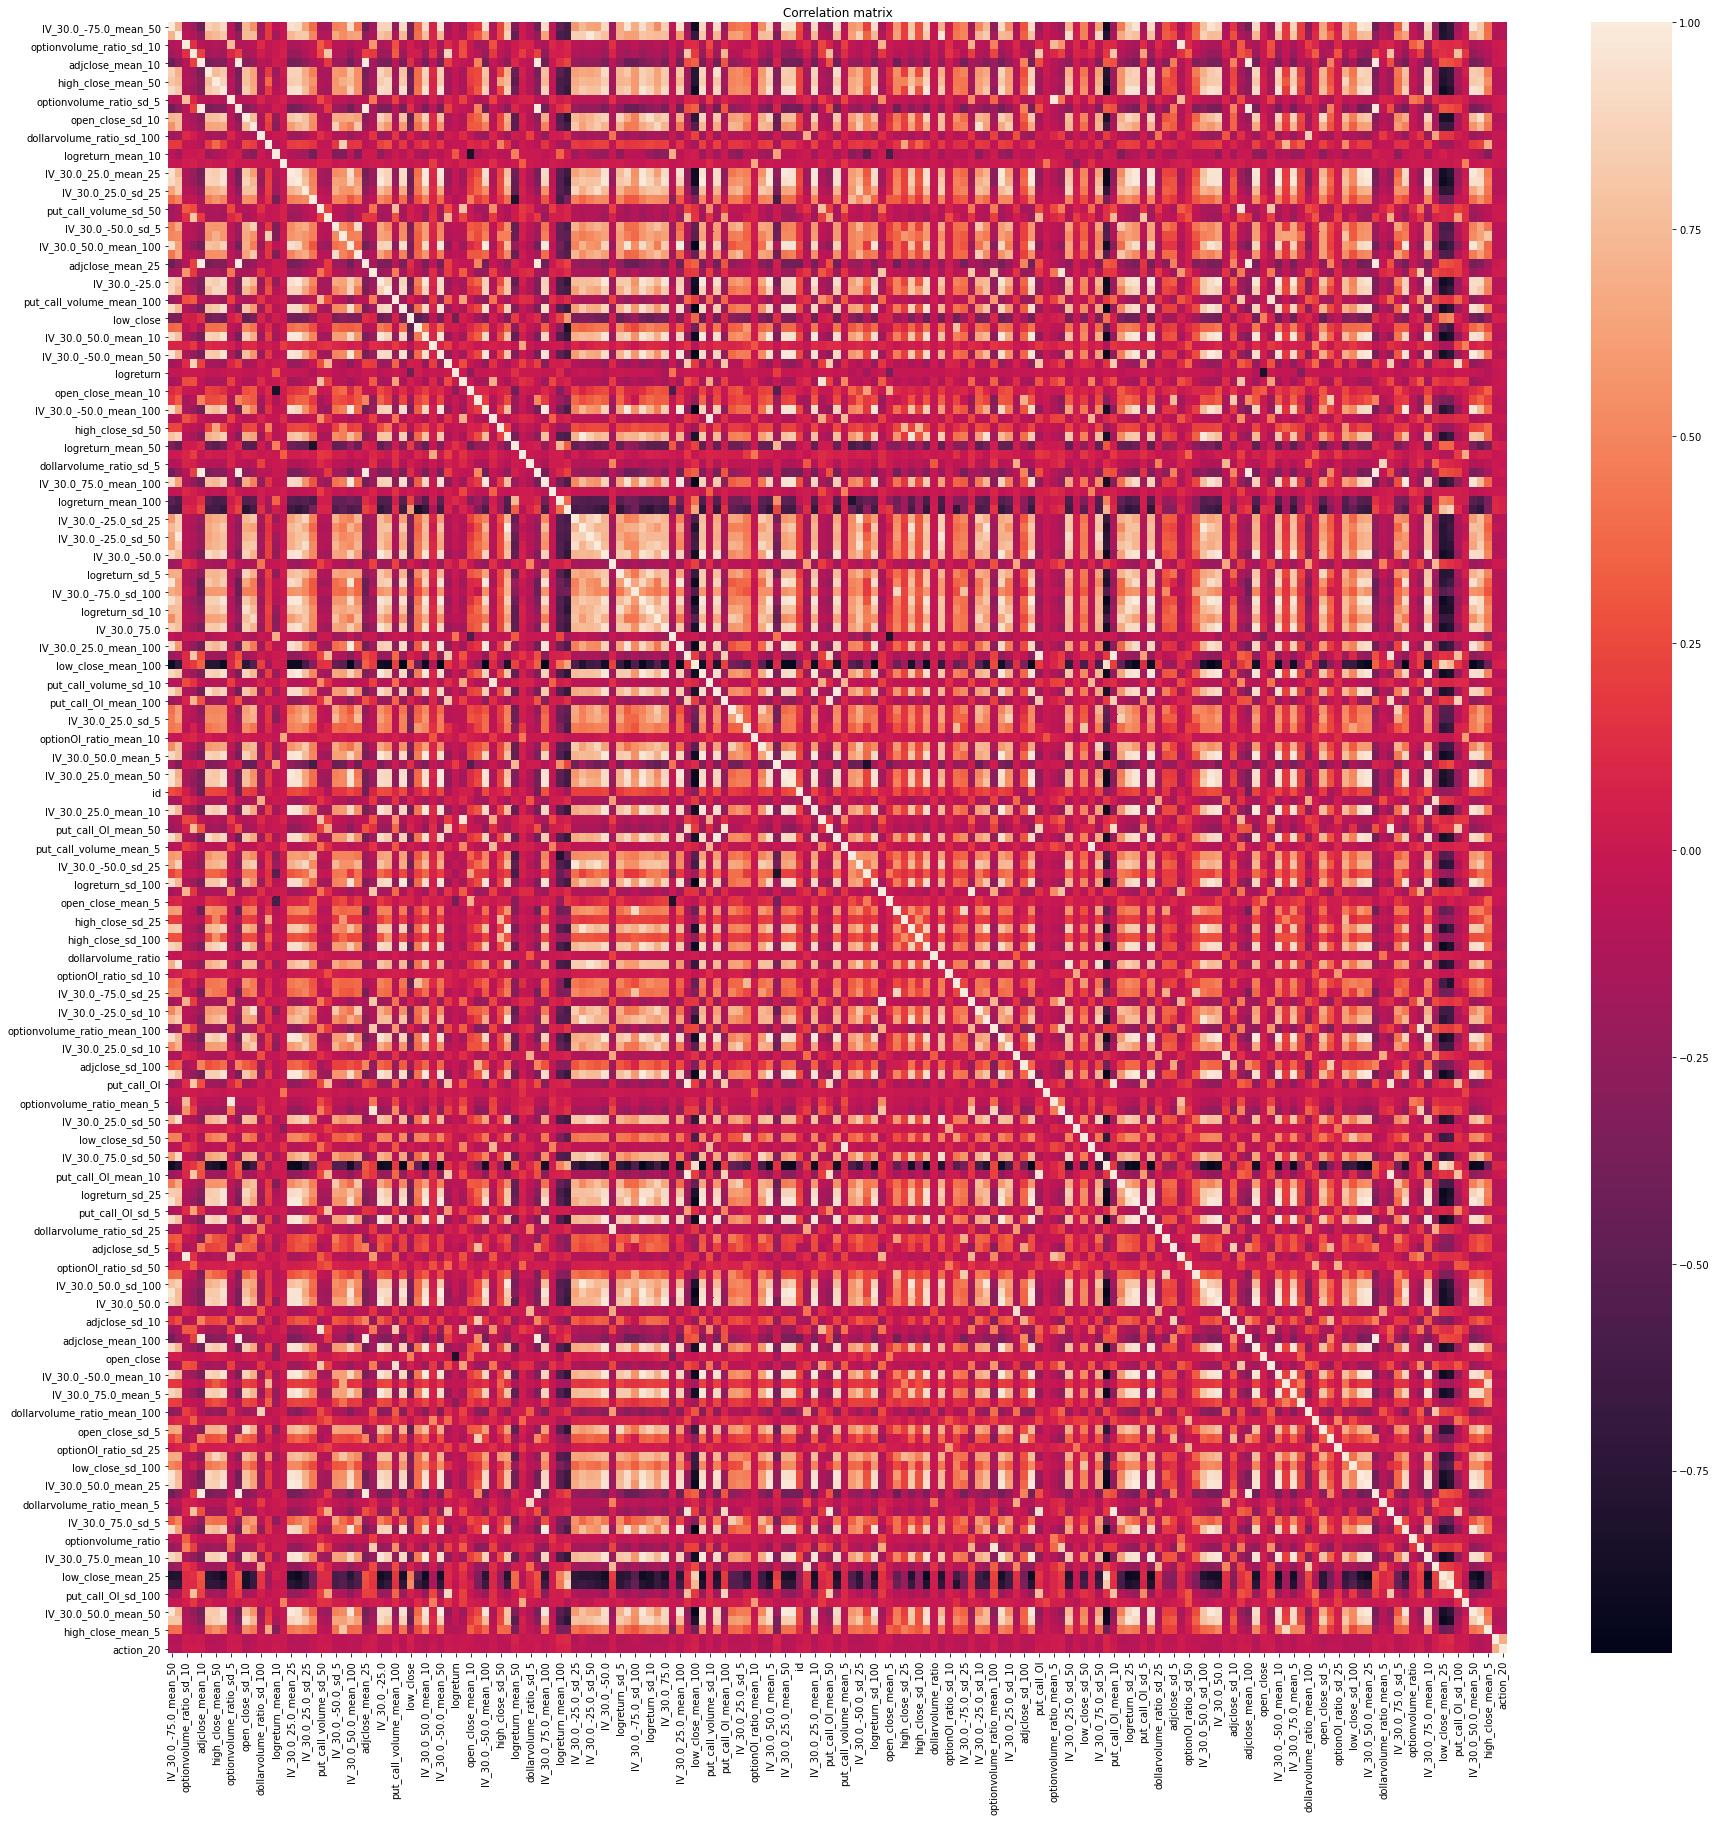

In [33]:
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(), annot=False)
plt.title('Correlation matrix')
plt.show()

## Predictive model developement
Spliting into features and target datasets:

In [34]:
X = df.iloc[:, 0:-2]
y = df.iloc[:, -1]

In [35]:
X.head()

,IV_30.0_-75.0_mean_50,IV_30.0_-50.0_sd_50,optionvolume_ratio_sd_10,put_call_OI_sd_25,adjclose_mean_10,IV_30.0_-75.0,high_close_mean_50,logreturn_sd_50,optionvolume_ratio_sd_5,adjclose_mean_5,...,optionvolume_ratio_sd_100,IV_30.0_75.0_mean_10,dollarvolume_ratio_mean_50,low_close_mean_25,low_close_mean_10,put_call_OI_sd_100,optionOI_ratio_mean_25,IV_30.0_50.0_mean_50,open_close_sd_25,high_close_mean_5
0,0.433818,0.032448,1.121406,0.027948,28.647753,0.382974,1.013195,0.025473,1.193495,29.315763,...,4.051361,0.434305,1.101670,0.981600,0.986295,0.103123,1.013351,0.419346,0.022293,1.009478
1,0.429686,0.032721,1.155757,0.031617,28.866723,0.373258,1.013438,0.024323,1.184125,29.703249,...,4.052991,0.423299,1.098457,0.981762,0.985608,0.101578,1.009447,0.419145,0.022278,1.010139
2,0.428257,0.033075,1.154503,0.035030,29.168438,0.372383,1.012878,0.024041,1.128617,30.250170,...,4.049316,0.425032,1.090692,0.982531,0.985778,0.099995,1.009850,0.419351,0.021743,1.011835
3,0.428597,0.033213,1.092696,0.039074,29.376056,0.436254,1.014080,0.025199,0.577142,30.356628,...,4.029476,0.418001,1.095259,0.982340,0.985476,0.098712,1.008362,0.419339,0.024290,1.023331
4,0.427857,0.033214,1.106032,0.042628,29.462332,0.414365,1.014628,0.025820,0.579427,30.030696,...,4.027542,0.421216,1.098127,0.983326,0.986780,0.096492,1.008108,0.420022,0.025244,1.029808


In [36]:
y.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: action_20, dtype: int64

## Principal Component Analisys
Determine how many PCA components are needed to capture a 90% of the variance ratio to reduce feature dataset dimensions.

In [37]:
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(X)

cum_variance_percentage = np.cumsum(pca.explained_variance_ratio_)
features = range(pca.n_components_)

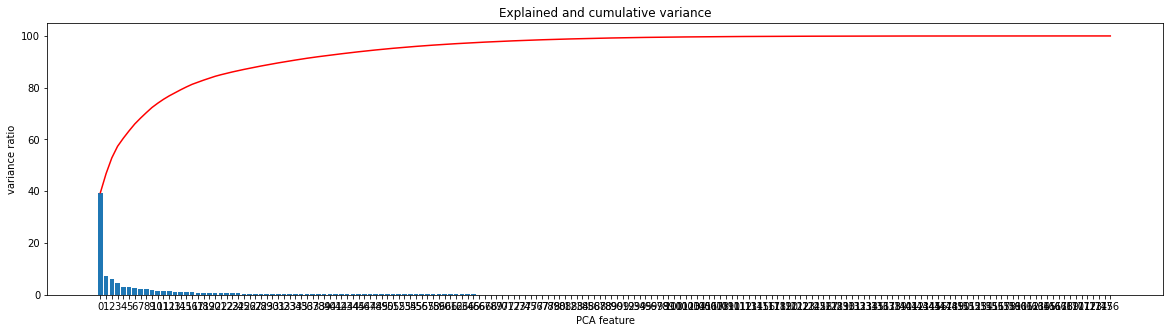

In [38]:
# Plot the explained variances
plt.figure(figsize=(20,5))
plt.bar(features,pca.explained_variance_ratio_*100)
plt.plot(features, cum_variance_percentage*100, c='r')
plt.xlabel('PCA feature')
plt.ylabel('variance ratio')
plt.title('Explained and cumulative variance')
plt.xticks(features)
plt.show()

### Components to capture a given level of variance

In [39]:
variance_captured = 0.9
n_components = sum(cum_variance_percentage <= variance_captured)
print('n_components for ' + str(variance_captured*100) + '% variance caputred: ' + str(n_components))

n_components for 90.0% variance caputred: 33


## Reduced feature dataset

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components = n_components)
X_pca = pd.DataFrame(pca.fit_transform(X_scaled))
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,9.305327,0.629591,-2.114593,-4.481234,0.199822,0.862841,-0.836798,1.356026,-0.762740,7.495868,...,-1.260828,-0.230070,2.333154,-3.300843,-1.175962,1.629114,0.143822,-4.937534,-2.511294,0.981278
1,8.915810,-0.447405,-2.452644,-4.230264,0.161961,0.449802,-1.396484,1.222346,-0.164336,5.639547,...,-0.989266,-0.196019,1.418244,-2.785641,-0.466328,1.551355,0.159862,-3.049178,-1.946952,0.654491
2,8.655782,-0.475770,-2.801648,-4.198893,0.561762,1.304059,-2.152517,1.336046,0.254950,5.270331,...,-1.123360,-1.051039,0.967900,-1.603483,-0.572883,2.028175,0.535414,-3.124932,-2.062484,0.686073
3,9.953558,0.201679,-1.930465,-1.871604,0.616239,2.051791,2.555882,0.420625,-0.589231,4.812195,...,-1.531710,-0.032882,1.916234,-2.553857,-1.276459,2.127824,-1.236637,-3.435335,-2.149667,0.455639
4,9.983766,0.210741,-1.668352,-1.021403,0.697751,2.025360,4.578549,-0.020750,-1.421345,4.076417,...,-0.236623,-0.766356,0.482000,-2.551343,-1.600417,2.951258,-1.301692,-2.325963,-1.853669,-0.298416


## ML prediction model classifier

### Train and testing datasets

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=15)
print('train length: ' + str(len(y_train)))
print('test length: ' + str(len(y_test)))

train length: 27061
test length: 6766


### Grid search hyperparameter tuning of Random Forest Classifier

In [42]:
params_rf = {'n_estimators':[5, 10, 20],
            'max_depth':[7, 8 , 9]}

scoring_rf = 'accuracy' # number of correctly guessed classes

rf = RandomForestClassifier(random_state=15)
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf, # dictionary with params
                       scoring=scoring_rf, # 'roc_auc',‘accuracy’... for classification // 'neg_mean_squared_error','r2'... for regression
                       cv=5, # k-fold CV
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)

# processing the previous model

best_hyperparams = grid_rf.best_params_
best_model = grid_rf.best_estimator_
best_score = grid_rf.best_score_
accuracy = best_model.score(X_test,y_test)
print(best_model)

y_pred = best_model.predict(X_test)

print("The accuracy of the RF is {:.2f}%".format(100*accuracy))

RandomForestClassifier(max_depth=9, n_estimators=20, random_state=15)
The accuracy of the RF is 66.02%
